In [1]:
import os
from functools import partial
import cx14

import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.trainer.trainer import Trainer

from PIL import Image, ImageDraw

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
img_dir = '/home/tstrebel/assets/chest-xray-14/images/images'
target_dir = '/home/tstrebel/assets/chest-xray-14'

target_map = {'No Finding':0, 'Atelectasis':1, 'Cardiomegaly':2, 'Consolidation':3, 'Edema':4,
       'Effusion':5, 'Emphysema':6, 'Fibrosis':7, 'Hernia':8, 'Infiltration':9,
       'Mass':10, 'Nodule':11, 'Pleural_Thickening':12, 'Pneumonia':13, 'Pneumothorax':14}

train_val_df = pd.read_csv(os.path.join(target_dir, 'train_val_list.txt'), header=None, index_col=0).index
target_df = pd.read_csv(os.path.join(target_dir, 'Data_Entry_2017.csv'), usecols=[0, 1])
target_df.columns = ['file_name', 'target']
target_df = target_df[(target_df['file_name'].isin(train_val_df)) & ~(target_df.target.str.contains('\|'))]
target_df.target = target_df.target.map(target_map)
target_map = list(target_map.keys())
del(train_val_df)

X_train, X_val = train_test_split(target_df, stratify=target_df.target, test_size=.2, random_state=99)
X_val, X_test = train_test_split(X_val, stratify=X_val.target, test_size=.4, random_state=99)
train_ix, val_ix, test_ix = list(X_train.index), list(X_val.index), list(X_test.index)
del(X_train)
del(X_val)
del(X_test)

bbox_df = pd.read_csv(os.path.join(target_dir, 'BBox_List_2017.csv')).iloc[:, 0:6]
bbox_df.columns = ['file_name', 'target', 'x', 'y', 'w', 'h']

len(train_ix), len(val_ix), len(test_ix)

(58776, 8817, 5878)

In [15]:
class_weights = (1-target_df.loc[train_ix].target.value_counts() / len(target_df)).sort_index().round(2).values
class_weights = torch.from_numpy(class_weights).float()

In [ ]:
mean = [0.5341]
std = [0.2232]

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(512),
    torchvision.transforms.CenterCrop(448),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std),
])

test_dataset = cx14.CX14Dataset(img_dir, target_df.loc[test_ix], num_classes=len(target_map), transform=transform)
test_dataloader = cx14.get_data_loader(test_dataset, 32, shuffle=False, num_workers=4)

In [3]:
model = cx14.Densenet121.load_from_checkpoint('/home/tstrebel/models/cx14/cx14-densenet.ckpt')

In [30]:
with torch.no_grad():
    running_targets = torch.empty((0, 1), dtype=torch.long).cuda()
    running_outputs = torch.torch.empty((0, 15)).cuda()
    
    model.eval()
    
    for inputs, targets in test_dataloader:
        inputs = inputs.cuda()
        targets = targets.cuda()
        
        outputs = model(inputs)
        
        running_targets = torch.vstack((running_targets, targets))
        running_outputs = torch.vstack((running_outputs, outputs))

accuracy:	0.7812
f1:		0.3168
recall:		0.3571
precision:	0.3276


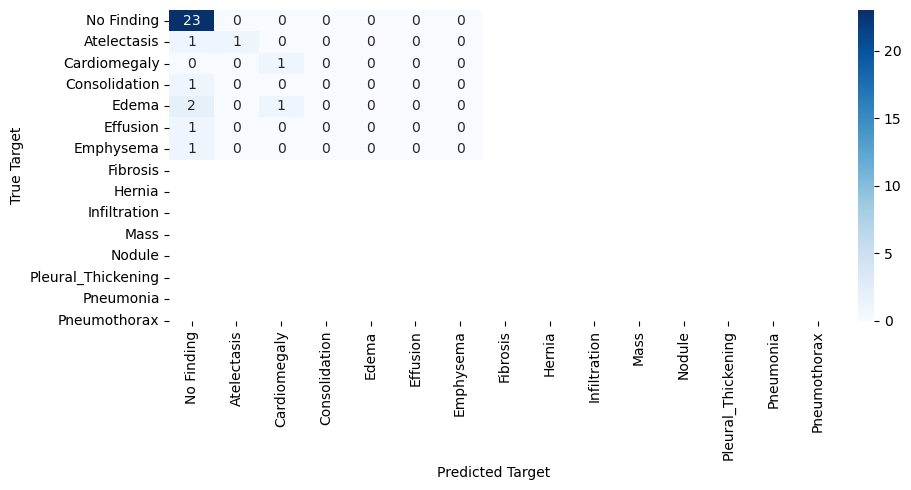

In [29]:
from sklearn import metrics

y_true = running_targets.cpu().detach().numpy()
y_pred = running_outputs.argmax(dim=1).cpu().detach().numpy()

accuracy_score = metrics.accuracy_score(y_true, y_pred)
f1_score = metrics.f1_score(y_true, y_pred, average='macro', zero_division=0)
recall_score = metrics.recall_score(y_true, y_pred, average='macro', zero_division=0)
precision_score = metrics.precision_score(y_true, y_pred, average='macro', zero_division=0)

print('accuracy:\t{:.4f}'.format(accuracy_score)) 
print('f1:\t\t{:.4f}'.format(f1_score)) 
print('recall:\t\t{:.4f}'.format(recall_score)) 
print('precision:\t{:.4f}'.format(precision_score))

cf_matrix = metrics.confusion_matrix(y_true, y_pred)
fig = plt.figure(dpi=100, figsize=(10,5))
sns.heatmap(cf_matrix, annot=True, fmt=',', cmap='Blues', xticklabels=target_map, yticklabels=target_map)
plt.xlabel('Predicted Target')
plt.ylabel('True Target')
fig.tight_layout()
plt.show()

In [21]:
bbox_df['target'].value_counts()

Atelectasis     180
Effusion        153
Cardiomegaly    146
Infiltrate      123
Pneumonia       120
Pneumothorax     98
Mass             85
Nodule           79
Name: target, dtype: int64

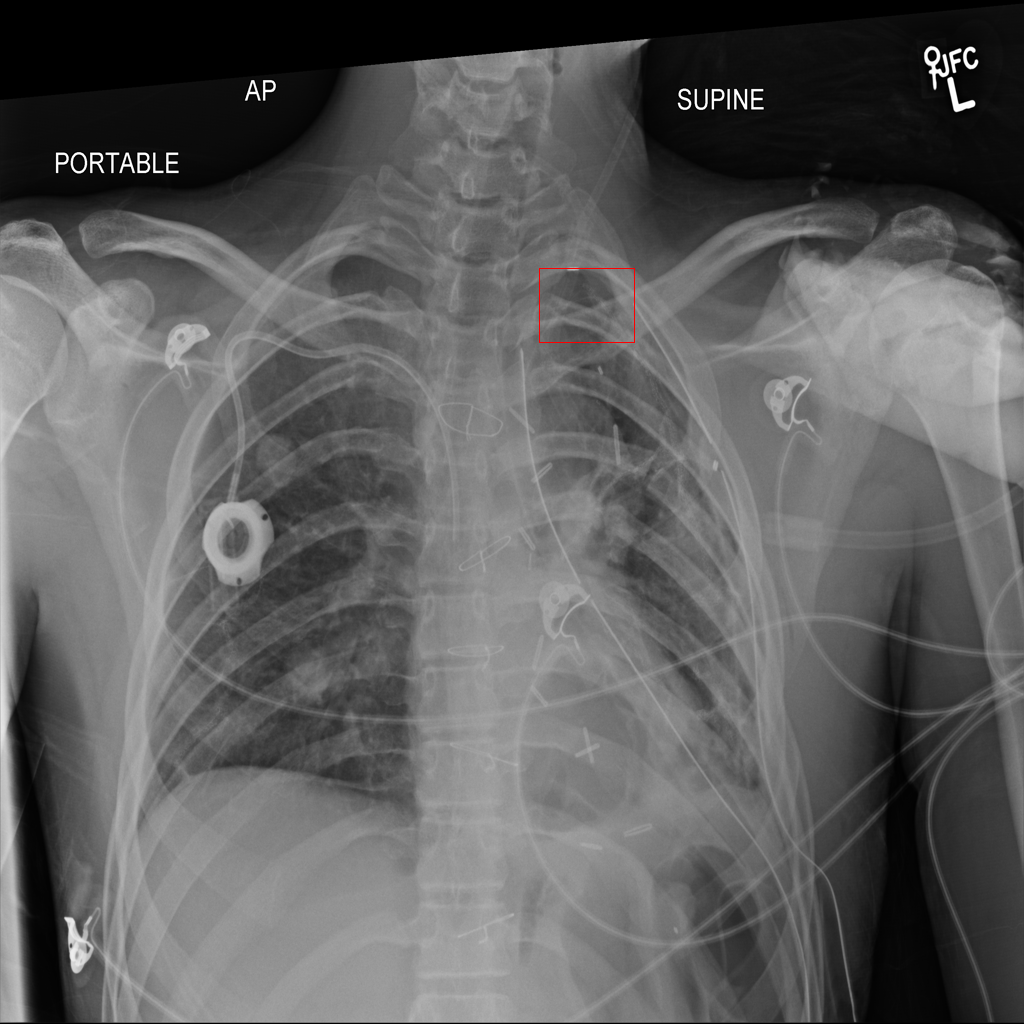

In [45]:
pt = bbox_df[bbox_df['target'] == 'Pneumothorax'].iloc[1]

file_name = pt.file_name
img_path = os.path.join(img_dir, file_name)

img = Image.open(img_path).convert("RGB")
shape = [(pt.x, pt.y), (pt.x + pt.w, pt.y + pt.h)]
img1 = ImageDraw.Draw(img)
img1.rectangle(shape, outline ="red")

img.show()